In [ ]:
#matplotlib 한글깨짐방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
#xls 읽기 위해
!pip install xlrd==1.2.0 
#geoPandas
!pip install geopandas #geopandas
!pip install rtree pygeos

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

import os
import tqdm
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.font_manager as fm 
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

from xlrd import open_workbook
from collections import defaultdict

warnings.filterwarnings(action='ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DACON - 6조

## 주제  
**서울시 지하철 우대권 혜택 축소에 따른 효과 분석 : 교통 혼잡 개선과 운임 기회비용 측면을 중심으로**

## 목차  
###  1. 서론
###  2. 본론
###  2-1. 현황 분석 및 현재 문제 해결의 필요성
###  2-2. 각 대안의 제시 및 검증, 예상 효과 분석
###  3. 참고 자료
---

## 서론
 현재 고령화 인구가 지속적으로 증가<sup>[1](https://www.dbpia.co.kr/journal/articleDetail?nodeId=NODE07058589)</sup>함에 따라 철도 무임승차 대상자 역시 증가하고 있다<sup>[2](https://www.dbpia.co.kr/Journal/articleDetail?nodeId=NODE07064975)</sup>. 따라서 관련 기관의 무임 손실비용이 급격하게 커지고 있다.<sup>[3](https://www.etoday.co.kr/news/view/2171664)</sup> 서울시에서 무임수송에 대한 비용 일부를 부담<sup>[4](https://www.dbpia.co.kr/Journal/articleDetail?nodeId=NODE11044573)</sup>하기 때문에, 해당 문제는 서울시의 재정적인 부담과도 이어진다. 이 문제를 해결하기 위한 대안들이 여러 차례 연구가 되고 있는 중이다.<sup>[5](https://www.dbpia.co.kr/journal/articleDetail?nodeId=NODE09217073), [6](https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002039001)</sup> 이 대안들 중에서 몇 가지 방법을 재정적인 측면에서 효율성을 재고해보고자 한다.

또한 일부 단어를 구체적으로 정의하여 분석에 활용하였으며 이는 다음과 같다.
  * 아침 : 07시-10시 전까지
  * 오후 : 14시-17시 전까지
  * 저녁 : 18시-21시 전까지
  * 노인층 : 우대권 사용이 가능한 법적 연령 65세 이상의 인구층
  * 봄 : 4,5월
  * 여름 : 7,8월
  * 가을 : 10,11월
  * 겨울 : 1,2월
  * 무임승차 인원 : 정확히는 승차 횟수를 의미; 승차인원 / 하차인원 중 승차인원만을 고려하였고, 무임승차자를 모두 '노인'이 이용했다고 가정함

아침과 저녁은 출퇴근 시간대를 고려해 선정하였으며 오후는 평소의 일상적인 상황을 가정하기 위해 설정하였다. 또한, 계절 역시 바뀌어가는 시기를 제외하고 계절의 특징이 뚜렷이 드러나는 구간만을 설정해 특징을 관찰하고자 하였다.

## 본론  

### 현황 분석 및 현재 문제 해결의 필요성

  1. 우대권 사용 인구 중 노년층 비율 분석
  2. 서울시 지하철 이용 현황 분석
    *   서울시 지하철역 중 출퇴근 시간대 총 승하차자, 우대권 이용자 수 상위 10개역
    *   서울시 지하철 아침/저녁 승하차 전체 승객수  집계
    *   서울시 지하철 아침/저녁 승하차 우대권 승객수 집계
    *   서울시 지하철 총 우대권 사용수 집계
    *   서울시 지하철 월 평균 우대권 승객 수 상위 10개역
    *   서울시 지하철 우대권 승객 비율 상위 10개역
  3. 서울시 대중교통 환승 이용패턴 분석
    *   서울시 대중교통 이용패턴 총 승객수 집계
    *   서울시 대중교통 이용패턴 일반 승객수 집계
    *   서울시 대중교통 이용패턴 노인 승객수 집계
  4. 서울시 시간 별 지하철 이용 현황 분포도 기반 분석
    *   서울시 아침/오후/저녁 시간대 승하차 전체 승객수 분포도
    *   서울시 아침/오후/저녁 시간대 승하차 일반 승객수 분포도
    *   서울시 아침/오후/저녁 시간대 승하차 우대권 승객수 분포도
    *   서울시 계절별 승하차 우대권 승객수 분포도
  5. 서울시 연도별 노인 거주 현황 분포도
  6. 서울시 호선별 우대권 승객수 집계
  7. 서울시 시간대별 총 승객 수 대 노인 승객 수 비율 분석
  8. 서울시 무임승차 개선안 별 선호도 설문 조사 결과 분석
  9. 정리
  

  ### 각 대안의 제시 및 검증, 예상 효과 분석
  
  **1. 기존 데이터 탐색 및 분석 결과**
   - 전자교통시스템의 발달로 승차자와 하차자에 관련한 비교적 정확한 데이터를 다수 발견할 수 있었다. 
   - 하지만 이러한 데이터의 경우 데이터 마스킹, 가명처리, 총계처리, 데이터 범주화 등의 개인정보 식별 방지 기술이 적용되어 있어, 승하차자의 정보에 대한 추적과 개인 표적화를 할 수 있는 데이터는 없었다.
   - 이러한 이유로, 우대권 이용자 개인에 관련된 패턴을 분석하기보다는 집단의 패턴과 경향성 분석에 집중하기로 결정하였다.
   - 연령 별, 시간 별, 성 별 등 판단해야 할 요소가 많았기 때문에 각종 시각화 자료와 표를 활용, 유의미한 형태를 보이는 요소를 선별하기로 하였다.
   - 대안은 크게 교통 혼잡도 개선 효과, 운임 기회비용의 감소규모, 대안별 선호도 세가지 요소에 의해 평가하기로 하였다.

**2. 분석해볼 대안**
   - 우대권 적용 연령 70세로 상향 조정
      - 서울시 거주 인구 데이터 활용, 65세-70세 인구 비율 파악 (2017년-2021년 서울시 나이별 인구 비율 월단위/연단위로 파악 후 65-70세 인구 비율을 어떻게 설정할 지 생각할 예정)
      - 2022년 이후 무임승차 인원 예상 (2020년 이전의 데이터 활용해 회귀 계수 계산 후, 2022년 무임승차 인원 데이터로 y절편 계산 후 Linear Regression 적용해서 예측; 2020-2022는 코로나 때문에 인구 변동폭이 크기 때문)
      - 위 자료를 토대로, 위 대안을 적용했을 시 2023년 무임승차 사용 인원 및 요금 계산 예정
   
   - 상시 운임 할인율 50%로 조정
      - 논문에 나와 있는 survey 활용 (65세 이상 노인분들이 무임승차 혜택을 제한받을 시, 철도를 계속 사용할 것인 지 사용하지 않을 것인 지를 조사한 자료가 존재)
      - 위의 자료를 기반으로, 50%로 조정했을 때 철도를 이용하는, 철도를 이용하지 않는 인원을 계산 후 무임승차 요금 계산 예정

   - 출퇴근시간 동안 우대권 할인 혜택 제외
      - 년도별/월별 시간에 따른 무임승차 인원 비율 파악 (ex. 2020년도 8월 기준, 무임승차 이용 인원 중 07시-08시에 사용하는 인원의 비율 - 15%, 08시-09시에 사용하는 인원 비율 - 10% , ...)
      - 각 시간의 비율에 해당하는 무임승차 인원의 비율을 제외한 후, 무임승차 인원의 변화 계산
   

  
  **3. 대안의 결과 분석 방안**
   - 교통 혼잡도 개선은 출퇴근 시간대의 혼잡한 상위역 대상으로 감소될 이용자 예측 수를 바탕으로 평가.
   - 운임 기회비용 규모는 감소할 이용 건당 현재 지하철 이용 최소요금 1250원씩 계산.
   - 대안별 선호도는 다른 논문에서 인용한 선호도 설문조사를 바탕으로 평가<sup>[7](http://dl.nanet.go.kr/law/SearchDetailView.do?cn=NONB1201420898)</sup>

## 현황 분석

### 0. 공통 전처리 코드 
> 활용 데이터 : [B],[C],[F],[G],[H]

In [ ]:
#csv, xls 파일 읽고 전처리 하는 함수
def read_df(y=2022, m=9, sheet=2): #sheet 2: 월별 무임유임 승하차 데이터, sheet3: 일별시간별 승하차데이터, 4: 노인 일별 시간대별 승하차 데이터. 5: 행정동 단위 인구 거주 데이터
  rootdir = '/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료' #승하차 데이터 루트
  dir_subway_eld = '/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_역별 일별 시간대별 노인 승하차인원 정보_20220531.csv' #노인 승하차 데이터 루트
  dir_live = '/content/drive/MyDrive/DACON6/서울시 인구 거주/서울시 행정동 단위 생활인구' #서울 행정동 단위 인구 거주데이터 루트

  sub_dirs = {} #sub_dirs[year][month]로 해당 월의 xls 파일경로를 가져올 수 있도록 딕셔너리 만듦.

  #sheet 별 df 읽기
  if sheet < 4:
    for year in os.listdir(rootdir):
      sub_sub_dirs = {}
      for month in os.listdir(os.path.join(rootdir, year)):
        sub_sub_dirs[int(month.split(' ')[1][:2])] = os.path.join(rootdir, year, month)
      sub_dirs[int(year)] = sub_sub_dirs
    df = pd.read_excel(sub_dirs[y][m], sheet_name=sheet, thousands=',')
  elif sheet==4:
    df = pd.read_csv(dir_subway_eld, encoding='cp949')
  elif sheet==5:
    df = pd.read_csv(dir_live+f"/LOCAL_PEOPLE_DONG_{y}{'0' if m < 10 else ''}{m}.csv")

  #sheet 마다 거칠 전처리
  if sheet==2:
    df = df.drop(columns=['호선명', '역ID', '작업일시', '사용월'])
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  elif sheet==3:
    df = df.iloc[1:, 3:-1]
    c = ['지하철역']
    for i in range(24):
      c.append(f'{(i+3)%24}시승차')
      c.append(f'{(i+3)%24}시하차')
    df.columns = c
    temp = df['지하철역']
    df = df[df.columns[1:]].astype('int')
    df['지하철역'] = temp
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  elif sheet==4:
    df = df.drop(columns=['연번', '역번호', '구분'])
    df['연월'] = df['일자'].apply(lambda x : '-'.join(x.split('-')[:2]))
    df = df[df['연월']==f"{y}-{'0' if m < 10 else ''}{m}"]
    df = df.groupby(by='역명').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  elif sheet==5:
    pass
  return df

#전처리한 데이터프레임을 geoPandas 데이터프레임으로 변환
def to_geodf(df, epsg=5179):
  dir_station = '/content/drive/MyDrive/DACON6/지하철 시설 정보/서울시 역사마스터 정보.csv' #역 좌표 데이터
  df_station = pd.read_csv(dir_station, encoding='cp949')
  df_station = df_station.drop(columns=['역사_ID', '호선'])
  df_station = df_station.groupby(by='역사명').mean()
  df_station['지하철역'] = df_station.index
  df_station.index = list(range(len(df_station))) #읽어와서 필요없는 컬럼 지우고 중복되는 역은 좌표를 평균냄

  df = pd.merge(df, df_station, on='지하철역') #역 좌표 데이터를 승하차 데이터와 통합

  s = gpd.GeoSeries([Point(x, y) for x, y in zip(df['위도'], df['경도'])]) #위도 경도 데이터를 GeoSeries Point 로 변환
  
  geodf = gpd.GeoDataFrame(df, geometry=s) # GeoDataFrame 생성
  geodf.crs = 'epsg:4326' #현재 좌표계는 위도경도(epsg4326)
  geodf = geodf.to_crs(epsg=epsg) #경계 데이터 좌표계는(epsg5179) 이걸로 변환
  geodf = geodf.drop(columns=['위도', '경도']) #기존 위도 경도는 제거
  
  return geodf

#geoPandas 데이터프레임을 서울시 행정동 경계 내 밀도 데이터로 결합, geoPandas 데이터프레임과 geoJson으로 리턴.
def to_density(geodf):
  geodf = geodf.drop(columns=['지하철역'])
  dir_shp = '/content/drive/MyDrive/DACON6/서울시 지리 정보/통계지역경계/행정구역.shp' #.shp 파일 경로(서울시 행정구역 단위 경계 데이터)
  seoul = gpd.read_file(dir_shp) #경계 데이터 읽기
  seoul.crs = 'epsg:5179' # 좌표계

  temp = []
  #geodf을 통해 경계 구역 내 지하철 역의 데이터를 모두 더해 밀도로 변환
  station_pos = geodf.geometry
  for i, g in enumerate(seoul.geometry):
    idx = station_pos.within(g)
    temp.append(geodf[idx].iloc[:, :-1].sum().to_numpy().T)

  temp = np.stack(temp)
  c = geodf.columns[:-1]
  for i, col in enumerate(c):
    seoul[col] = temp[:, i]

  seoul = seoul.to_crs(epsg=4326)

  return seoul, seoul.to_json()

### 1. 우대권 사용 인구 중 노년층 비율 분석
> 활용 데이터 : [A]

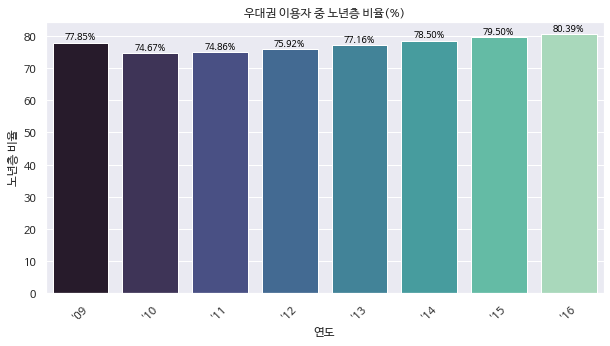

In [ ]:
dirr = '/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사 무임수송, 우대권 관련/역별_무임수송_실적(1992년-2016년).csv'
df_rate = pd.read_csv(dirr, encoding='cp949', thousands = ',' )
df_rate['노년층 비율'] = df_rate['노인(천명)'].astype('float')/(df_rate['계(무임수송인원)'].astype('float'))*100
df_rate = df_rate[['연도', '계(무임수송인원)', '노인(천명)', '장애인(천명)','노년층 비율']][-8:]
df_rate=df_rate.reset_index(drop=True)

sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=df_rate['연도']
y=df_rate['노년층 비율']
sns.barplot(x=x,y=y,palette="mako").set(title='우대권 이용자 중 노년층 비율(%)')
plt.xticks(rotation=45)
for i, v in enumerate(df_rate.index):
    plt.text(v, y[i], '{:,.2f}%'.format(y[i]),              
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()

2010년을 제외하면 이후 우대권 이용자중 노년층의 비율은 미약하고 완만하게 매년 증가하는 추세이며 변동의 폭이 크지 않음을 알 수 있다.

### 2. 서울시 지하철 이용 현황 분석


####서울시 지하철역 중 출퇴근 시간대[출처추가. 아침: 7시-9시, 저녁 : 18시-20시] 총 승하차자, 우대권 이용자 수 상위 10개역.


####서울시 지하철 아침/저녁 승하차 전체 승객 수 집계

In [ ]:
#시간대별 전체 승하차
ampm_total = read_df(2022, 5, 3)

time_dict = {'아침승차':['7시승차', '8시승차'], '아침하차':['7시하차', '8시하차'], '점심승차':['14시승차','15시승차'], '점심하차':['14시하차','15시하차'], '저녁승차':['18시승차', '19시승차'], '저녁하차':['18시하차', '19시하차']}
for s in ['아침승차', '아침하차', '점심승차', '점심하차', '저녁승차', '저녁하차']:
  ampm_total[s] = ampm_total[time_dict[s]].mean(axis=1)

#아침승하차, 저녁승하차  
total_ampm=ampm_total[['아침승차','아침하차','저녁승차','저녁하차']].astype(int)
total_ampm.insert(0,'지하철역',ampm_total['지하철역'])
total_ampm['아침승하차']=total_ampm['아침승차']+total_ampm['아침하차']
total_ampm['저녁승하차']=total_ampm['저녁승차']+total_ampm['저녁하차']

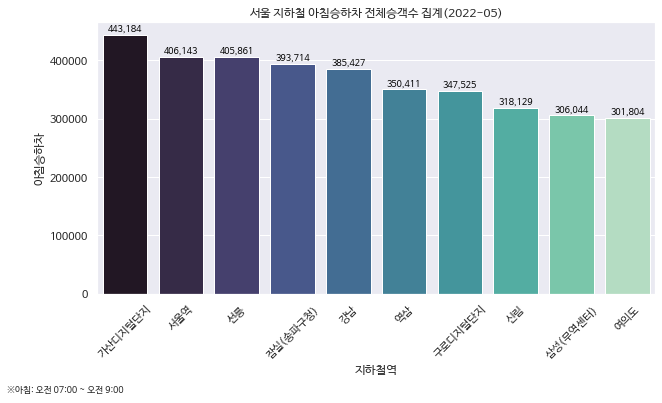

In [ ]:
#아침승하차, 저녁승하차 합계만
total_ampm = total_ampm.drop(columns=['아침승차', '아침하차', '저녁승차', '저녁하차'])
#아침승하차 순위
total_am=(total_ampm
        .drop(columns=['저녁승하차'])
        .sort_values('아침승하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=total_am['지하철역']
y=total_am['아침승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울 지하철 아침승하차 전체승객수 집계(2022-05)')
plt.xticks(rotation=45)
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
#수치값 표시
for i, v in enumerate(total_am.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()

아침시간대의 일반적인 승차와 하차 인원 합계 순위. 상위권간의 수적 차이가 크지 않으며 10위와 1위의 격차가 50% 미만을 보이고 있다.

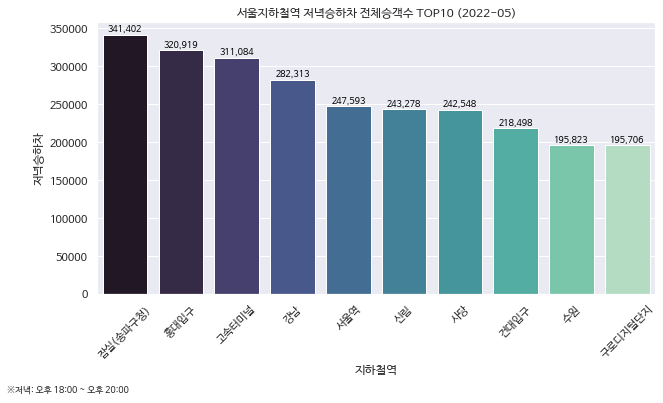

In [ ]:
#저녁승하차 순위
total_pm=(total_ampm
        .drop(columns=['아침승하차'])
        .sort_values('저녁승하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=total_pm['지하철역']
y=total_pm['저녁승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울지하철역 저녁승하차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(total_pm.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

저녁시간대의 일반적인 승차와 하차 인원 합계 순위. 상위권간의 수적 차이가 여전히 큰편은 아니지만 아침에 비해 편중현상을 확인할 수 있다.

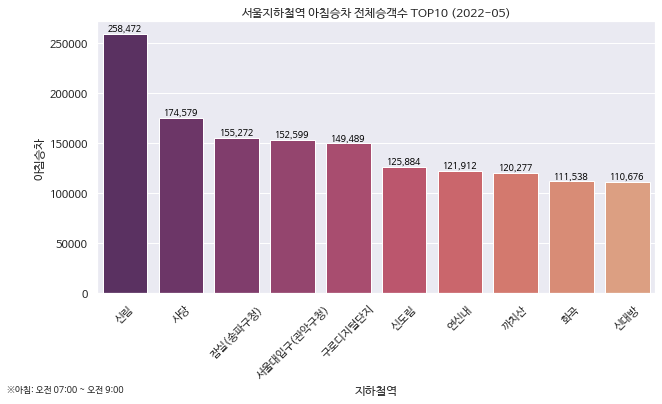

In [ ]:
#아침승차
total_am_on=(ampm_total[['지하철역','아침승차']]
        .sort_values('아침승차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
total_am_on['아침승차']=total_am_on['아침승차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=total_am_on['지하철역']
y=total_am_on['아침승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=total_am_on,palette=palette).set(title='서울지하철역 아침승차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(total_am_on.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()


아침시간대의 일반적인 승차 인원 순위. 승차와 하차를 분리 한 결과 승하차 데이터에 비해 독보적인 역이 존재함을 알 수 있다. 특히 상위 5개 역을 제외하면 10만 초반대의 인원수를 보여 골고루 이용하고 있음을 관찰 할 수 있다.

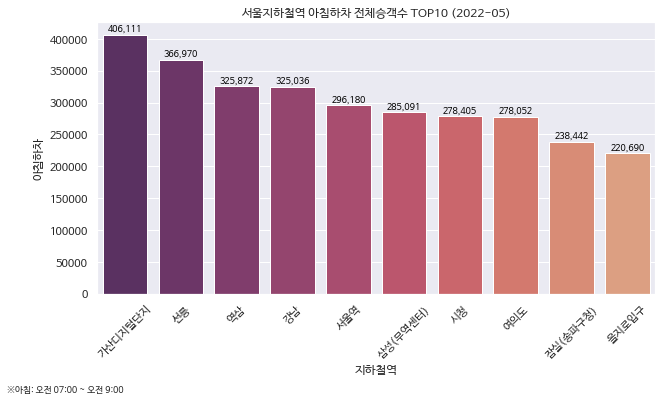

In [ ]:
#아침하차
total_am_off=(ampm_total[['지하철역','아침하차']]
        .sort_values('아침하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
total_am_off['아침하차']=total_am_off['아침하차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=total_am_off['지하철역']
y=total_am_off['아침하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
sns.barplot(x=x,y=y,data=total_am_on,palette=palette).set(title='서울지하철역 아침하차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
plt.xticks(rotation=45)

#수치값 표시
for i, v in enumerate(total_am_off.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

아침시간대의 일반적인 하차 인원 순위. 승차 순위에 비하면 완곡도 절대량도 고르게 분포되어 있음을 관찰 할 수 있다.

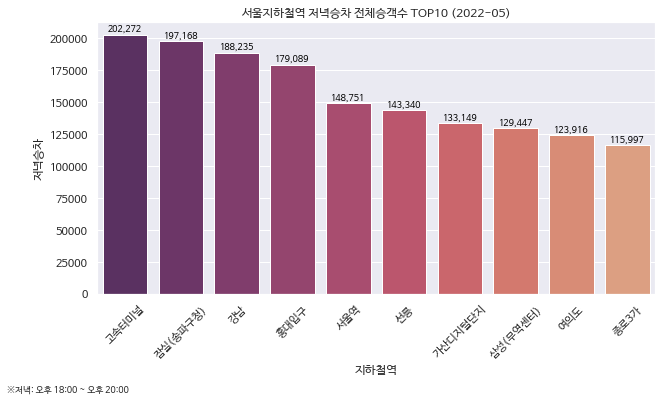

In [ ]:
#저녁승차
total_pm_on=(ampm_total[['지하철역','저녁승차']]
        .sort_values('저녁승차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
total_pm_on['저녁승차']=total_pm_on['저녁승차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=total_pm_on['지하철역']
y=total_pm_on['저녁승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
sns.barplot(x=x,y=y,data=total_am_on,palette=palette).set(title='서울지하철역 저녁승차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
plt.xticks(rotation=45)
#수치값 추가
for i, v in enumerate(total_pm_on.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')   
plt.show()

퇴근 시간대로 설정한 오후 6시-8시 구간의 승차 인원. 아침 하차 표와 사뭇 다른 순위임을 확인 할 수 있다.

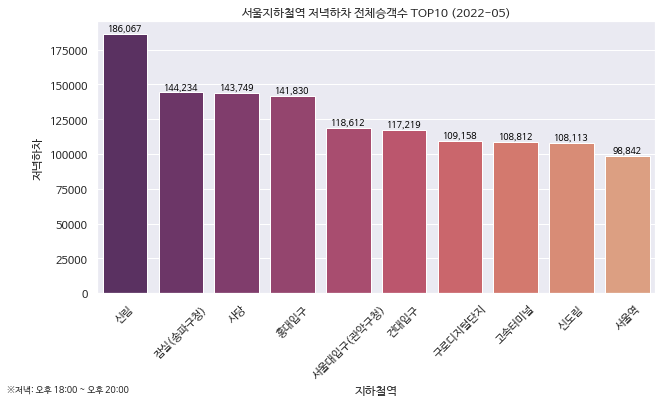

In [ ]:
total_pm_off=(ampm_total[['지하철역','저녁하차']]
        .sort_values('저녁하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
total_pm_off['저녁하차']=total_pm_off['저녁하차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=total_pm_off['지하철역']
y=total_pm_off['저녁하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
sns.barplot(x=x,y=y,data=total_am_on,palette=palette).set(title='서울지하철역 저녁하차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 추가
for i, v in enumerate(total_pm_on.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')  
plt.show()

저녁시간동안의 하차 분포도. 전체적인 분포도나 절대량이 아침승차량과 유사하게 나옴을 확인 할 수 있다. 실제 거주지로 돌아가는 인원수라 보아도 무방해 보인다.

####서울시 지하철 아침/저녁 승하차 우대권 승객 수 집계
> 활용 데이터 : [C]

In [ ]:
senior_ampm=pd.read_csv('/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_역별 일별 시간대별 노인 승하차인원 정보_20220531.csv',encoding='cp949')
senior_ampm.head()

FileNotFoundError: ignored

In [ ]:
#월단위로 추출하기 위해 date 타입으로 바꿔줌
senior_ampm['일자'] = pd.to_datetime(senior_ampm['일자'])
#5월 데이터 추출
query_month = 5 
senior_ampm_f = senior_ampm.query('일자.dt.month == @query_month')
#아침승하차, 저녁승하차 합계
senior_ampm_f =senior_ampm_f[['역명','07시-08시','08시-09시','18시-19시','19시-20시']]
senior_ampm_f= senior_ampm_f.groupby(senior_ampm_f['역명']).sum()
senior_ampm_f.reset_index(level=['역명'], inplace = True)
senior_ampm_f['아침승하차']=senior_ampm_f['07시-08시']+senior_ampm_f['08시-09시']
senior_ampm_f['저녁승하차']=senior_ampm_f['18시-19시']+senior_ampm_f['19시-20시']
senior_ampm_f=senior_ampm_f.drop(columns=['07시-08시','08시-09시','18시-19시','19시-20시'])

NameError: ignored

In [ ]:
#노인 아침승하차
senior_am=(senior_ampm_f
        .drop(columns=['저녁승하차'])
        .sort_values('아침승하차',ascending=False)
        .iloc[:10]
        )
senior_am['아침승하차']=senior_am['아침승하차'].astype(int)
senior_am=senior_am.reset_index(drop=True)

sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=senior_am['역명']
y=senior_am['아침승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울지하철역 아침승하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)

#텍스트 회전
plt.xticks(rotation=45)

#수치값 추가
for i, v in enumerate(senior_am.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom') 

plt.show()

전체적으로 전체승객수 집계와 비슷하게 고른 분포를 보이나, 더 완만한 감소폭을 보이는것, 그리고 서울역을 제외하면 주 이용 역이 사뭇 다른것을 알 수 있다. 

In [ ]:
#노인 저녁 승하차
senior_pm=(senior_ampm_f
        .drop(columns=['아침승하차'])
        .sort_values('저녁승하차',ascending=False)
        .iloc[:10]
        )
senior_pm['저녁승하차']=senior_pm['저녁승하차'].astype(int)
senior_pm=senior_pm.reset_index(drop=True)
senior_pm
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=senior_pm['역명']
y=senior_pm['저녁승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울지하철역 저녁승하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 추가
for i, v in enumerate(senior_pm.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom') 

plt.show()

저녁 시간대의 이용은 더 극단적인데, 아직 승차와 하차를 분리하지 않았음에도 아침 승차 승객수처럼 종로 3가 역이 압도적 이용률을 보임을 알 수 있다.

In [ ]:
#5월 데이터 추출
query_month = 5 
senior_onoff = senior_ampm.query('일자.dt.month == @query_month')

#승차데이터만 추출
senior_on=senior_onoff[senior_onoff['구분']=='합계 : 승차']

#아침승차
senior_am_on =senior_on[['역명','07시-08시','08시-09시']]
senior_am_on['아침승차']=senior_am_on['07시-08시']+senior_am_on['08시-09시']
senior_am_on=senior_am_on.drop(columns=['07시-08시','08시-09시'])
senior_am_on= senior_am_on.groupby(senior_am_on['역명']).sum()

#아침승차 top10
senior_am_on=(senior_am_on
        .sort_values('아침승차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
senior_am_on['아침승차']=senior_am_on['아침승차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=senior_am_on['역명']
y=senior_am_on['아침승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=senior_am_on,palette=palette).set(title='서울지하철역 아침승차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(senior_am_on.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()


승하차 데이터에 비해 격차는 약간 벌어졌지만 고른 분포를 확인 할 수 있다. 승차 역들 또한 승하차 데이터와 일치하는 비율이 높다.

In [ ]:
#하차데이터만 추출
senior_off=senior_onoff[senior_onoff['구분']=='합계 : 하차']

#아침하차
senior_am_off =senior_off[['역명','07시-08시','08시-09시']]
senior_am_off['아침하차']=senior_am_off['07시-08시']+senior_am_off['08시-09시']
senior_am_off=senior_am_off.drop(columns=['07시-08시','08시-09시'])
senior_am_off= senior_am_off.groupby(senior_am_off['역명']).sum()

#아침하차 top10
senior_am_off=(senior_am_off
        .sort_values('아침하차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
senior_am_off['아침하차']=senior_am_off['아침하차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=senior_am_off['역명']
y=senior_am_off['아침하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=senior_am_off,palette=palette).set(title='서울지하철역 아침하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(senior_am_off.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

아침의 하차 데이터는 명확하게 특정 역에 편중되어 있음을 관측할 수 있다. 종로 5가, 동대문, 을지로 4가 등과 사당, 교대, 고속터미널 등 아침 출근시간에 하차하는 지역군이 명확하게 존재함을 알 수 있다.

In [ ]:
#저녁승차
senior_pm_on =senior_on[['역명','18시-19시','19시-20시']]
senior_pm_on['저녁승차']=senior_pm_on['18시-19시']+senior_pm_on['19시-20시']
senior_pm_on=senior_pm_on.drop(columns=['18시-19시','19시-20시'])
senior_pm_on= senior_pm_on.groupby(senior_pm_on['역명']).sum()

#아침승차 top10
senior_pm_on=(senior_pm_on
        .sort_values('저녁승차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
senior_pm_on['저녁승차']=senior_pm_on['저녁승차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=senior_pm_on['역명']
y=senior_pm_on['저녁승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=senior_pm_on,palette=palette).set(title='서울지하철역 저녁승차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(senior_pm_on.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

압도적인 불균형을 보이는 퇴근 시간대 승차 데이터. 종로 3가를 제외하고 종로5가와 동대문 역시 많은 이용량을 보이나, 종로3가에서 승차하는 승객수가 매우 많음을 알 수 있다. 추측할 수 있는 이유는 3개 호선이 교차하는 종로 3가역이 돌아가기 가장 좋은 환경이기 때문일 가능성이 있어보인다.

In [ ]:
#저녁하차
senior_pm_off =senior_off[['역명','18시-19시','19시-20시']]
senior_pm_off['저녁하차']=senior_pm_off['18시-19시']+senior_pm_off['19시-20시']
senior_pm_off=senior_pm_off.drop(columns=['18시-19시','19시-20시'])
senior_pm_off= senior_pm_off.groupby(senior_pm_off['역명']).sum()

#저녁하차 top10
senior_pm_off=(senior_pm_off
        .sort_values('저녁하차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
senior_pm_off['저녁하차']=senior_pm_off['저녁하차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=senior_pm_off['역명']
y=senior_pm_off['저녁하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=senior_pm_off,palette=palette).set(title='서울지하철역 저녁하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트회전
plt.xticks(rotation=45)


#수치값 표시
for i, v in enumerate(senior_pm_off.index):
    plt.text(v, y[i], '{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

퇴근시간대의 노인층 하차 데이터. 고른 분포를 보이며 놀랍게도 아침 승차 데이터와 형태도, 상위권 역들의 이름도 매우 유사함을 관측 할 수 있었다. 일반 승객들과 마찬가지로, 귀가를 위해 이용하는것을 추측 할 수 있다.

####서울시 지하철 월 평균 우대권 승객 수 상위 10개역
> 활용 데이터 : [D]

In [ ]:
discount=pd.read_csv('/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_권종별 승차인원_20220531.csv',encoding='cp949')
discount.head()

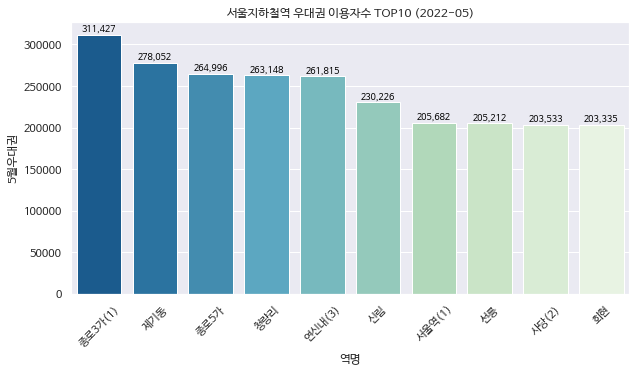

In [ ]:
discount_top10=(discount[['역명','5월우대권']]
    .sort_values('5월우대권',ascending=False)
    .reset_index(drop=True)
    .iloc[:10]
    )
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
palette = sns.color_palette("GnBu",n_colors=10)
palette.reverse() 
x=discount_top10['역명']
y=discount_top10['5월우대권']
sns.barplot(x=x,y=y,palette=palette).set(title='서울지하철역 우대권 이용자수 TOP10 (2022-05)')
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(discount_top10.index):
    plt.text(v, y[i],'{:,.0f}'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()

순수하게 역별로 우대권 승하차 데이터만 비교 해본 그래프. 퇴근 시간대 이용률이 압도적이었던 종로3가역과 제기동, 종로 5가, 청량리역 등 1호선 역들의 강세가 눈에 띔을 알 수 있다.

####서울시 지하철 우대권 승객 비율 상위 10개역

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


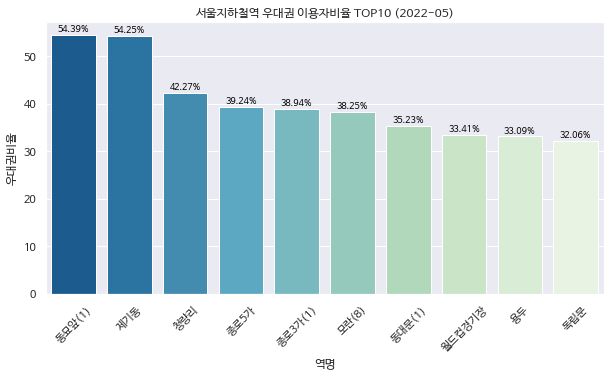

In [ ]:
discount_ratio=discount[['역명']]
discount_ratio['우대권비율']=(discount['5월우대권']/(discount['5월선불']+discount['5월후불']+discount['5월정기권']+discount['5월우대권']+discount['5월1회권']+discount['5월단체권']))*100
discount_ratio=(discount_ratio
                .sort_values('우대권비율',ascending=False)
                .reset_index(drop=True)
                .iloc[:10]
                )
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
palette = sns.color_palette("GnBu",n_colors=10)
palette.reverse() 
x=discount_ratio['역명']
y=discount_ratio['우대권비율']
sns.barplot(x=x,y=y,palette=palette).set(title='서울지하철역 우대권 이용자비율 TOP10 (2022-05)')
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(discount_ratio.index):
    plt.text(v, y[i], '{:,.2f}%'.format(y[i]),                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()

단순히 유동량이 많은 역이 집계 되었을 가능성도 있기 때문에, 일반 이용자와 노인 이용자의 비율 순으로 집계를 해본 결과, 약 40% 이상이 노인 이용객인 역들의 특징이 엿보인다.

### 3. 서울시 대중교통 환승 이용패턴 분석
> 활용 데이터 : [E]

In [ ]:
#2021.11.30~2022.09.22 목적통행_패턴
df=pd.read_csv('/content/drive/MyDrive/DACON6/지하철 이용 정보/서울시 대중교통 이용패턴 정보.csv',encoding='cp949')

In [ ]:
#목적통행_패턴 기준으로 합침
pattern=df.drop(columns=['기준_날짜'])
pattern=pattern.groupby(df['목적통행_패턴']).sum() 
pattern.reset_index(level=['목적통행_패턴'], inplace = True)

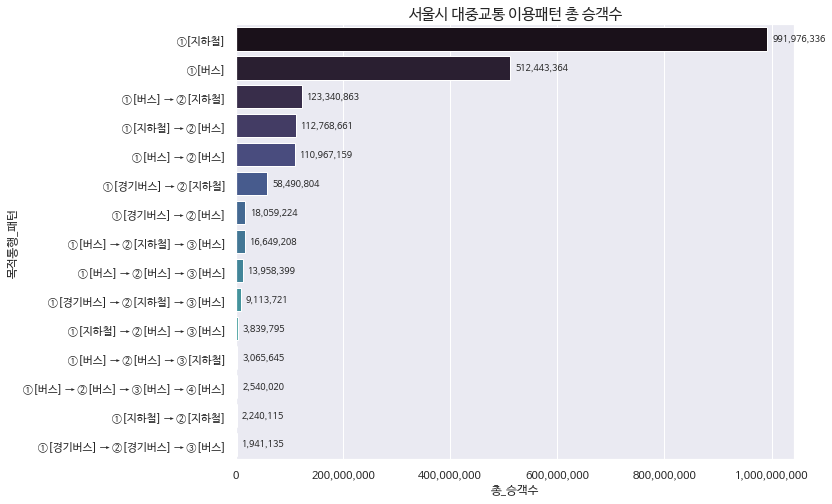

In [ ]:
#목적통행_패턴 총 승객수 top15
pattern_total=(pattern[['목적통행_패턴','총_승객수']]
                .sort_values('총_승객수',ascending=False)
                .reset_index(drop=True)
                .iloc[:15]
                )
sns.set(rc={"figure.figsize":(10, 8)})
plt.rc('font', family='NanumBarunGothic') 
x=pattern_total['총_승객수']
y=pattern_total['목적통행_패턴']
ax=sns.barplot(x=x,y=y,palette="mako",data=pattern_total,orient='h')
ax.set_title('서울시 대중교통 이용패턴 총 승객수',fontsize=15)
#수치값 표시
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.8),fontsize=9,
                xytext=(5, 10), textcoords='offset points')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]) 
plt.show()

환승 패턴을 기반으로 분류한 총 이용자 기반 빈도수 그래프. 지하철 1번으로 그치는 이용 빈도가 가장 많으며 버스 1번이 그 뒤를 이어 절반의 빈도수를 기록했다.
1번 환승패턴들이 그 뒤를 잇고 있으며 생각보다 지하철-지하철 환승 패턴은 적음을 알 수 있다.

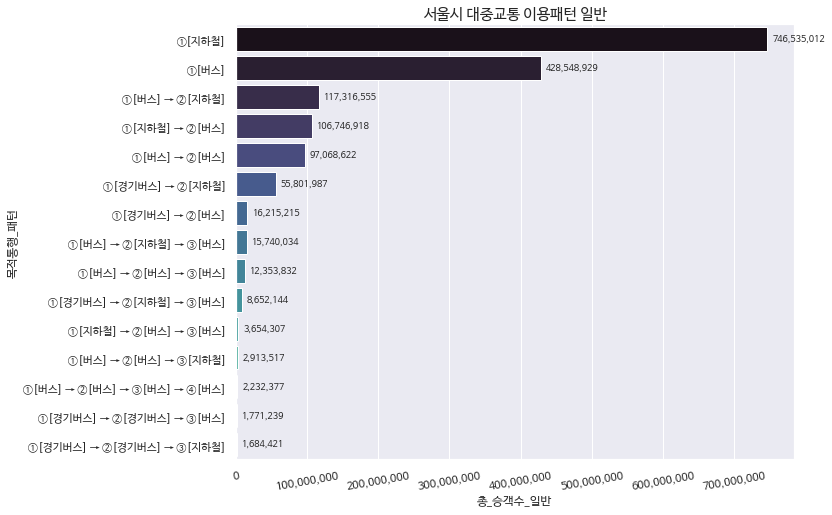

In [ ]:
#목적통행_패턴 일반 승객수 top15
pattern_regular=(pattern[['목적통행_패턴','총_승객수_일반']]
                .sort_values('총_승객수_일반',ascending=False)
                .reset_index(drop=True)
                .iloc[:15]
                )
pattern_regular['총_승객수_일반']=pattern_regular['총_승객수_일반'].astype(int)   
sns.set(rc={"figure.figsize":(10, 8)})
plt.rc('font', family='NanumBarunGothic') 
x=pattern_regular['총_승객수_일반']
y=pattern_regular['목적통행_패턴']
ax=sns.barplot(x=x,y=y,palette="mako",data=pattern_regular,orient='h')
ax.set_title('서울시 대중교통 이용패턴 일반',fontsize=15)
# 수치값 표시
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.8),fontsize=9,
                xytext=(5, 10), textcoords='offset points')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
#텍스트 회전
plt.xticks(rotation=10) 
plt.show()

위의 일반 데이터와 큰 밀도 차이는 보이지 않는다. 다만 지하철 1회 패턴과 버스 1회 패턴 사이의 격차는 50%에서 약 40%로 감소함을 알 수 있다.

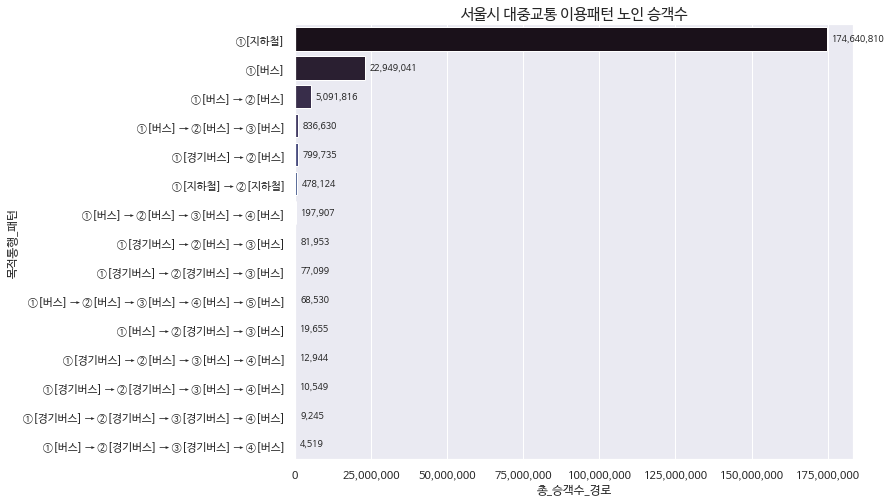

In [ ]:
#목적통행_패턴 노인 승객수 top15
pattern_senior=(pattern[['목적통행_패턴','총_승객수_경로']]
                .sort_values('총_승객수_경로',ascending=False)
                .reset_index(drop=True)
                .iloc[:15]
                )
pattern_senior['총_승객수_경로']=pattern_senior['총_승객수_경로'].astype(int) 
sns.set(rc={"figure.figsize":(10, 8)})
plt.rc('font', family='NanumBarunGothic') 
x=pattern_senior['총_승객수_경로']
y=pattern_senior['목적통행_패턴']
ax=sns.barplot(x=x,y=y,palette="mako",data=pattern_senior,orient='h')
ax.set_title('서울시 대중교통 이용패턴 노인 승객수',fontsize=15)
# 수치값 표시
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.8),fontsize=9,
                xytext=(5, 10), textcoords='offset points')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]) 

plt.show()

패턴 별 노인 탑승객의 대중교통 이용 패턴. 일반 승객이 1회 환승까지는 나름의 지분을 차지하고 있었음과 비교하면, 소수의 버스2회 이용 패턴을 제외하면 노인층의 이동 패턴은 지하철을 이용해 직통으로 이동하는 방식이 절대 다수를 차지함을 알 수 있다.

### 4. 서울시 시간 별 지하철 이용 현황 분포도 기반 분석

In [ ]:
#지도 색상 설정
cmap='Blues'
edgecolor='black'

####1. 서울시 아침/오후/저녁 시간대 승하차 전체 승객수 분포도

In [ ]:
#전체 승객 수 데이터 읽어오기
df = read_df(2022, 5, 3)

#시간대별 컬럼 정의
time_dict = {'아침승하차':['7시승차', '8시승차', '7시하차', '8시하차'], '점심승하차':['14시승차','15시승차', '14시하차','15시하차'],'저녁승하차':['18시승차', '19시승차', '18시하차', '19시하차']}
time_list = ['아침승하차','점심승하차', '저녁승하차']
t_list = ['아침', '오후', '저녁']

#평균 구하기
for s in time_list:
  df[s] = df[time_dict[s]].mean(axis=1)

#geoPandas로 변환하고 행정동 밀도 데이터로 변환
geodf = to_geodf(df)
seoul, seoul_json = to_density(geodf)

#컬러맵 최대 최소 정의
vm = np.max([seoul['아침승하차'].max(), seoul['점심승하차'].max(), seoul['저녁승하차'].max()]) * 0.8

#애니메이션으로 플롯
plt.rc('font', family='NanumBarunGothic') 
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('서울시 시간별 지하철 승하차 전체 승객수 분포도', fontsize=25)
ax.axis('off')

def update(i):
  ax.set_title(t_list[i], fontsize=20)
  plot = seoul.plot(time_list[i], ax=ax, vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)
  plt.close()

  return plot

norm = mpl.colors.Normalize(vmin=0, vmax=vm)
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)

ani = FuncAnimation(fig, update, frames=range(len(time_list)), interval=1000, repeat_delay=3000, blit=False)
HTML(ani.to_jshtml())

####2. 서울시 아침/오후/저녁 시간대 승하차 일반 승객수 분포도

In [ ]:
#전체 승객수 데이터 읽어오기
df1 = read_df(2022, 5, 3)

#시간대별 컬럼 정의
time_dict = {'아침승하차':['7시승차', '8시승차', '7시하차', '8시하차'], '점심승하차':['14시승차','15시승차', '14시하차','15시하차'],'저녁승하차':['18시승차', '19시승차', '18시하차', '19시하차']}
time_list = ['아침승하차','점심승하차', '저녁승하차']
t_list = ['아침', '오후', '저녁']

#평균 내기
for s in time_list:
  df1[s] = df1[time_dict[s]].mean(axis=1)

#노인 승객수 데이터 읽어오기
df2 = read_df(2022, 5, 4)

#시간별 컬럼 정의
time_dict = {'아침승하차':['07시-08시', '08시-09시'], '점심승하차':['14시-15시', '15시-16시'],'저녁승하차':['18시-19시', '19시-20시']}

#평균 내기
for s in time_list:
  df2[s] = df2[time_dict[s]].mean(axis=1)

df = df1.copy()

#두 데이터 빼서 일반 승객수 계산
for s in time_list:
  df[s] = df1[s] - df2[s]

#geoPandas 데이터프레임으로 변환하고 행정동 밀도 데이터로 변환
geodf = to_geodf(df)
seoul, seoul_json = to_density(geodf)

#컬러맵 최대 최소 정의
vm = np.max([seoul['아침승하차'].max(), seoul['점심승하차'].max(), seoul['저녁승하차'].max()]) * 0.8

#애니메이션으로 플롯
plt.rc('font', family='NanumBarunGothic') 
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('서울시 시간별 지하철 승하차 일반 승객수 분포도', fontsize=25)
ax.axis('off')

def update(i):
  ax.set_title(t_list[i], fontsize=20)
  plot = seoul.plot(time_list[i], ax=ax, vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)
  plt.close()

  return plot

norm = mpl.colors.Normalize(vmin=0, vmax=vm)
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)

ani = FuncAnimation(fig, update, frames=range(len(time_list)), interval=1000, repeat_delay=3000, blit=False)
HTML(ani.to_jshtml())

####3. 서울시 아침/오후/저녁 시간대 승하차 우대권 승객수 분포도

In [ ]:
#노인 승객 수 데이터 읽기
df = read_df(2022, 5, 4)

#시간대별 컬럼 정의
time_dict = {'아침승하차':['07시-08시', '08시-09시'], '점심승하차':['14시-15시', '15시-16시'],'저녁승하차':['18시-19시', '19시-20시']}
time_list = ['아침승하차','점심승하차', '저녁승하차']
t_list = ['아침', '오후', '저녁']

#평균 내기
for s in time_list:
  df[s] = df[time_dict[s]].mean(axis=1)

#geoPandas 데이터프레임으로 변환하고 행정동 밀도 데이터로 변환
geodf = to_geodf(df)
seoul, seoul_json = to_density(geodf)

#컬러맵 최대 최소 정의
vm = np.max([seoul['아침승하차'].max(), seoul['점심승하차'].max(), seoul['저녁승하차'].max()]) * 0.8

#애니메이션으로 플롯
plt.rc('font', family='NanumBarunGothic') 
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('서울시 시간별 지하철 승하차 우대권 승객수 분포도', fontsize=25)
ax.axis('off')

def update(i):
  ax.set_title(t_list[i], fontsize=20)
  plot = seoul.plot(time_list[i], ax=ax, vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)
  plt.close()

  return plot

norm = mpl.colors.Normalize(vmin=0, vmax=vm)
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)

ani = FuncAnimation(fig, update, frames=range(len(time_list)), interval=1000, repeat_delay=3000, blit=False)
HTML(ani.to_jshtml())

####4. 서울시 계절별 승하차 우대권 승객수 분포도

In [ ]:
#계절 별 월 정의
season_dict = {'봄':[4, 5], '여름':[7, 8], '가을':[10, 11], '겨울':[1, 2]}
season_list = ['봄', '여름', '가을', '겨울']

#월별 유임, 무임 승하차 데이터 읽기
df = read_df(2021, 1, 2)

#우대권 승객수만 분리
for key in season_dict:
    d1= read_df(2021, season_dict[key][0], 2)
    d2 = read_df(2021, season_dict[key][1], 2)
    df[key] = d1['무임승차'] + d1['무임하차'] + d2['무임승차'] + d2['무임하차']

#geoPandas 데이터프레임으로 변환하고 행정동 밀도 데이터로 변환
geodf = to_geodf(df)
seoul, seoul_json = to_density(geodf)

#컬러맵 최대 최소 정의
vm = np.max([seoul['봄'].max(), seoul['여름'].max(), seoul['가을'].max(), seoul['겨울'].max()]) * 0.9

#애니메이션으로 플롯
plt.rc('font', family='NanumBarunGothic') 
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('서울시 계절별 지하철 승하차 우대권 승객수 분포도', fontsize=25)
ax.axis('off')

def update(i):
  ax.set_title(season_list[i], fontsize=20)
  plot = seoul.plot(season_list[i], ax=ax, vmin=0, vmax=vm, cmap=cmap, edgecolor=edgecolor)
  plt.close()

  return plot

norm = mpl.colors.Normalize(vmin=0, vmax=vm)
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)

ani = FuncAnimation(fig, update, frames=range(len(season_list)), interval=1000, repeat_delay=3000, blit=False)
HTML(ani.to_jshtml())

### 5. 서울시 연도별 노인 거주 현황 분포도
> 활용 데이터 : [G],[I]

In [29]:
#.shp 파일 경로(서울시 행정구역 단위 경계 데이터)
dir_shp = '/content/drive/MyDrive/DACON6/서울시 지리 정보/통계지역경계/행정구역.shp'

#경계 데이터 읽기
seoul = gpd.read_file(dir_shp)
seoul = seoul.astype({'ADM_CD':'int64'})

#행정동코드 체계가 다를 경우 매핑을 위한 데이터 읽기
dir_code = '/content/drive/MyDrive/DACON6/서울시 지리 정보/행정동코드_매핑정보.xlsx'
cd = pd.read_excel(dir_code).iloc[1:, :2]
cd_to_cd = {}
for row in cd.itertuples():
  cd_to_cd[int(row.행자부행정동코드)] = row.통계청행정동코드

#데이터 읽었을때 컬럼이 밀리는 오류 때문에 65세 이상 생활인구수를 아래의 컬럼으로 읽어야 함.
target_erred = ['남자35세부터39세생활인구수', '남자40세부터44세생활인구수', '여자35세부터39세생활인구수', '여자40세부터44세생활인구수']
target = ['남자60세부터64세생활인구수', '남자65세부터69세생활인구수', '여자60세부터64세생활인구수', '여자65세부터69세생활인구수']

plt.rc('font', family='NanumBarunGothic') 
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('서울시 연도별 노인 거주 현황 분포도', fontsize=25)

vmax = 13000
vmin = 680

ims = []

#5년치 평균을 내어 애니메이션으로 플롯
dff = None
for i, year in enumerate([2017, 2018, 2019, 2020, 2021]):
  temp = []
  for month in range(1, 13):
    print(f'\r{year} {month}  ', end='')
    data=False
    try:
      df = read_df(year, month, 5)
      if type(df.index)!=pd.MultiIndex: #제대로 읽혔을 때, 컬럼 1개 밀림
        df = df.groupby(by='시간대구분').mean()
        data = df[target].to_numpy()
      else: #인덱스 오류 났을 때, 컬럼 7개 밀림
        df = df.reset_index().groupby(by='level_2').mean()
        data = df[target_erred].to_numpy()
    except:
      pass
    try:
      data = np.sum(data, axis=1)
      temp.append(data)
    except:
      pass

  dff = read_df(2017, 1, 5).reset_index().groupby(by='level_2').mean()
  dff['인구'] = np.mean(temp, axis=0)
  dff['ADM_CD'] = dff.index
  dff.index = list(range(len(dff)))
  dff['ADM_CD'] = dff['ADM_CD'].map(lambda x : cd_to_cd[x])
  ims.append(pd.merge(seoul, dff, on='ADM_CD'))

def update(i):
  ax.axis('off')
  ax.set_title(f'{i+2017}년도', fontsize=16)
  plot = ims[i].plot('인구', ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, edgecolor=edgecolor)
  plt.close()
  
  return plot

norm = mpl.colors.Normalize(vmin=0, vmax=vm)
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)
ani = FuncAnimation(fig, update, frames=range(len(ims)), interval=1000, repeat_delay=3000, blit=False)
HTML(ani.to_jshtml())

ERROR:fiona._env:/content/drive/MyDrive/DACON6/서울시 지리 정보/통계지역경계/행정구역.shp: No such file or directory


DriverError: ignored

생활인구 데이터를 기반으로 한 연도별 거주인구를 표현한 것이다. 과거에 비해 특정 노인층이 편중현상은 완화되어 가고 있음을 알 수 있다.

####시간별 노인 인구 분포
> [G],[I]

In [30]:
#22년 5월 시간별 유동인구 분포
dir_shp = '/content/drive/MyDrive/DACON6/서울시 지리 정보/통계지역경계/행정구역.shp' #.shp 파일 경로(서울시 행정구역 단위 경계 데이터)

seoul = gpd.read_file(dir_shp)
seoul = seoul.astype({'ADM_CD':'int64'})

dir_code = '/content/drive/MyDrive/DACON6/서울시 지리 정보/행정동코드_매핑정보.xlsx'
cd = pd.read_excel(dir_code).iloc[1:, :2]
cd_to_cd = {}
for row in cd.itertuples():
  cd_to_cd[int(row.행자부행정동코드)] = row.통계청행정동코드

vmax = 13000
vmin = 680

df = read_df(2022, 5, 5)
target = ['남자60세부터64세생활인구수', '남자65세부터69세생활인구수', '여자60세부터64세생활인구수', '여자65세부터69세생활인구수']
df = df.groupby(by=['시간대구분', '기준일ID']).mean().reset_index()

plt.rc('font', family='NanumBarunGothic') 
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('서울시 시간별 노인 거주 현황 분포도', fontsize=25)
ims = []

def update(i):
  if len(ims) > 0:
    ims[0].remove()
    del ims[0] 
  dff = df[df['기준일ID']==i].copy()
  dff['인구'] = np.sum(dff[target].to_numpy(), axis=1)
  dff['ADM_CD'] = dff['시간대구분']
  dff['ADM_CD'] = dff['ADM_CD'].map(lambda x : cd_to_cd[x])
  merged = pd.merge(seoul, dff, on='ADM_CD')

  ax.set_title(f'{i}시', fontdict={'fontsize': 20})
  ax.axis('off')
  plot = merged.plot('인구', ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, edgecolor=edgecolor)
  plt.close()

  return plot

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)

ani = FuncAnimation(fig, update, frames=range(7, 23), interval=1000, repeat_delay=3000, blit=False)
HTML(ani.to_jshtml())

ERROR:fiona._env:/content/drive/MyDrive/DACON6/서울시 지리 정보/통계지역경계/행정구역.shp: No such file or directory


DriverError: ignored

생활인구를 기반으로 한 노인층 주요 거점 조사. 여의동, 종로, 역삼, 서초 일대에 주로 모이는것을 확인 할 수 있다.

### 6. 서울시 호선별 우대권 승객수 집계
> 활용 데이터 : [B]

In [ ]:
# 2021.6-2022.05 까지 무임승하차 호선, 역별 합산
df1 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2022/2022년 01월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]
df2 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2022/2022년 02월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]
df3 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2022/2022년 03월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]
df4 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2022/2022년 04월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]
df5 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2022/2022년 05월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]
df6 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2021/2021년 06월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]
df7 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2021/2021년 07월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]
df8 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2021/2021년 08월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]
df9 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2021/2021년 09월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]
df10 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2021/2021년 10월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]
df11 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2021/2021년 11월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]
df12 = pd.read_excel('/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/2021/2021년 12월  교통카드 통계자료.xls', sheet_name= 2, thousands=',')[['호선명','지하철역','무임승차','무임하차']]

line = pd.merge(df1, df2, how='inner', on=['호선명', '지하철역'])
line['무임승하차'] = line['무임승차_x']+line['무임승차_y']+line['무임하차_x']+line['무임하차_y']
line = line.drop(columns=['무임승차_x', '무임승차_y', '무임하차_x', '무임하차_y'])
line = pd.merge(line, df3, how='inner', on=['호선명', '지하철역'])
line['무임승하차'] = line['무임승하차']+line['무임승차']+line['무임하차']
line = line.drop(columns=['무임승차', '무임하차'])
line = pd.merge(line, df4, how='inner', on=['호선명', '지하철역'])
line['무임승하차'] = line['무임승하차']+line['무임승차']+line['무임하차']
line = line.drop(columns=['무임승차', '무임하차'])
line = pd.merge(line, df5, how='inner', on=['호선명', '지하철역'])
line['무임승하차'] = line['무임승하차']+line['무임승차']+line['무임하차']
line = line.drop(columns=['무임승차', '무임하차'])
line = pd.merge(line, df6, how='inner', on=['호선명', '지하철역'])
line['무임승하차'] = line['무임승하차']+line['무임승차']+line['무임하차']
line = line.drop(columns=['무임승차', '무임하차'])
line = pd.merge(line, df7, how='inner', on=['호선명', '지하철역'])
line['무임승하차'] = line['무임승하차']+line['무임승차']+line['무임하차']
line = line.drop(columns=['무임승차', '무임하차'])
line = pd.merge(line, df8, how='inner', on=['호선명', '지하철역'])
line['무임승하차'] = line['무임승하차']+line['무임승차']+line['무임하차']
line = line.drop(columns=['무임승차', '무임하차'])
line = pd.merge(line, df9, how='inner', on=['호선명', '지하철역'])
line['무임승하차'] = line['무임승하차']+line['무임승차']+line['무임하차']
line = line.drop(columns=['무임승차', '무임하차'])
line = pd.merge(line, df10, how='inner', on=['호선명', '지하철역'])
line['무임승하차'] = line['무임승하차']+line['무임승차']+line['무임하차']
line = line.drop(columns=['무임승차', '무임하차'])
line = pd.merge(line, df11, how='inner', on=['호선명', '지하철역'])
line['무임승하차'] = line['무임승하차']+line['무임승차']+line['무임하차']
line = line.drop(columns=['무임승차', '무임하차'])
line = pd.merge(line, df12, how='inner', on=['호선명', '지하철역'])
line['무임승하차'] = line['무임승하차']+line['무임승차']+line['무임하차']
line = line.drop(columns=['무임승차', '무임하차'])

In [ ]:
# line은 호선과 역 두개 key로 따로 집계한 표
# line_g는 호선과 역 이름을 그룹화 하여 상위 20개 이용량을 기록한 역을 기록한것.
line_g = line.groupby(['호선명', '지하철역']).sum().sort_values('무임승하차', ascending= False)[:20]
line_g

무임승하차
호선명 지하철역                 
1호선 종로3가          5923338
    제기동           5921909
    청량리(서울시립대입구)  5565419
    종로5가          5316746
3호선 연신내           5276450
경부선 영등포           4666217
2호선 신림            4661537
경인선 부천            4242847
2호선 선릉            4109732
4호선 창동            3963266
    수유(강북구청)      3917205
2호선 신도림           3826771
1호선 서울역           3787159
분당선 모란            3758665
2호선 서울대입구(관악구청)   3689679
4호선 미아사거리         3658872
2호선 잠실(송파구청)      3657466
4호선 회현(남대문시장)     3621635
2호선 사당            3583469
    구로디지털단지       3467462

In [ ]:
line_g.groupby('호선명').sum().sort_values('무임승하차', ascending= False)

무임승하차
호선명          
2호선  26996116
1호선  26514571
4호선  15160978
3호선   5276450
경부선   4666217
경인선   4242847
분당선   3758665

상위 4개 역이 1호선, 하지만 총 이용자 수는 2호선이 근소하게 위임을 알 수 있다. 하지만 상위 4개 역이 모두 연간 50만명 이상의 노인층이 이용하는 역이며, 1,2호선을 제외하면 호선별 이용량이 급감하는것을 확인할 수 있다.

### 7. 서울시 시간대별 총 승객 수 대 노인 승객 수 비율 분석

In [ ]:
#22년 1월부터 5월까지 전체 지하철 승객수와 노인 지하철 승객수 읽기
dfs = []
for i in range(1, 6):
  tot_df = read_df(2022, i, 3).drop(columns=['3시승차', '3시하차', '4시승차', '4시하차', '5시승차', '5시하차', '0시승차', '0시하차', '1시승차', '1시하차', '2시승차', '2시하차'])
  eld_df = read_df(2022, i, 4).drop(columns=['06시이전', '23시이후'])

  #승하차 데이터 통합
  temp_columns = tot_df.columns[:-1]
  for h in range(6, 23):
    tot_df[f'{h}시'] = tot_df[f'{h}시승차'] + tot_df[f'{h}시하차']
  tot_df = tot_df.drop(columns=temp_columns)

  #데이터 통합
  df = pd.merge(tot_df, eld_df, on='지하철역')

  #노인 승객수 / 전체 승객수 비율 구하기
  temp_columns = df.columns[1:]
  for h in range(6, 23):
    df[f'{h}시비율'] = df[f"{0 if h < 10 else ''}{h}시-{0 if h+1 < 10 else ''}{h+1}시"] / df[f'{h}시']
  dfs.append(df.drop(columns=temp_columns))

#평균 내기
result = pd.concat(dfs)
result = result.groupby(by='지하철역').mean()
result = result.reset_index()

In [ ]:
result

NameError: ignored

### 8. 서울시 생활인구 시간 별 이동패턴 분석

5개월 간의 데이터를 취합하여 시간별 탑승자중 노인층 탑승자의 비율표. 전체적으로 10% 내외인 경우가 많지만 특정 역의 경우 30-40% 이상의 비율을 기록하는 시간, 역이 있다.

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig, axes = plt.subplots(6, 7, figsize=(18, 14))
def update(i):
  df = pd.read_csv(f"/content/drive/MyDrive/DACON6/서울시 인구 이동/서울시 8월 생활이동데이터/생활이동_행정동_2022.08_{'0' if i < 10 else ''}{i}시.csv", encoding='cp949')

  idx = df['이동인구(합)']=="*"
  df.loc[idx, '이동인구(합)'] = '1.0'
  day_list = [['월','Mon'], ['화','Tue'], ['수','Wed'], ['목','Thu'], ['금','Fri'], ['토','Sat'], ['일','Sun']]
  age_list = ['~20','20~30','30~40','40~50','50~60','60~']
  case_list = df['이동유형'].unique()
  case_list.sort()
  case_list = ['HW', 'HE', 'HH', 'EW', 'EE', 'EH', 'WH', 'WE', 'WW']

  for i, f1 in enumerate(day_list):
    for j, f2 in enumerate(age_list):
      if j == 0:
        idx_ = (df['요일'] == f1[0]) & (df['나이'] < 20)
      else:
        idx_ = (df['요일'] == f1[0]) & (10*(j+1) <= df['나이']) & (df['나이'] < 10*(j+2))
      
      df_1 = df.loc[idx_, :].copy()

      df_1['이동인구(합)'] = df_1['이동인구(합)'].astype(float)
      df_2 = df_1.groupby('이동유형')['이동인구(합)'].apply(sum)
      df_2 = df_2.reset_index()

      total_sum = df_2['이동인구(합)'].sum()
      df_2['이동인구(합)'] = df_2['이동인구(합)'].mul(100/total_sum)

      graph = sns.barplot(y='이동유형', x='이동인구(합)', data=df_2, order=case_list, ax=axes[j][i])
      graph.set(xlim=(0, 80))
      graph.xaxis.set_major_formatter(mtick.PercentFormatter())
      graph.set_xlabel(age_list[j]+', '+day_list[i][1])
      graph.set_ylabel('Type')
  plt.close()

ani = FuncAnimation(fig, update, frames=range(24), interval=1000, repeat_delay=3000, blit=False)
HTML(ani.to_jshtml())

H는 집, W는 일터, E는 그외. 각각 연령과 요일별로 이동 패턴을 기록한것이다. 전체적으로 주간과 주말의 이동 패턴이 구분됨을 알 수 있으며 이는 노인층에게도 예외는 아닌듯하다. 다만 역시 HW패턴은 다소 적음도 확인 가능하다.

### 9. 서울시 무임승차 개선안 별 선호도 설문 조사 결과 분석

개선안 별 설문조사 지지도

|1지망|지지도(%)|2지망|지지도(%)|3지망|지지도(%)|
|-----|---------|-----|---------|-----|---------|
|**소득계층별 차등**|23.8| ***연령 상향*** |19.2|**소득계층별 차등**|23.4|
|***연령 상향***|18.1|월 이용횟수 상한|17.6|전부 반대|15.6|
|할인률 일괄 하향|15.0|**소득계층별 차등**|14.6|할인률 일괄 하향|13.3|
|전부 반대|	13.6|	할인률 일괄 하향|	14.2|	현세대까지만|	12.5|
|월 이용횟수 상한|	10.8|	월 이용요금 상한|	14.2|	***연령 상향***|	12.5|
|현세대까지만|	9.1|	출퇴근 이외만|	8.8|	월 이용요금 상한|	10.9|
|월 이용요금 상한|	5.7|	현세대까지만|	8.4|	월 이용횟수 상한|	10.2|
|출퇴근 이외만|	4.0|	전부 반대|	3.1|	출퇴근 이외만|	1.6|

|채점안 A|점수| 채점안 B|점수|
|--------|----|---------|----|
|소득계층별 차등|61.8|소득계층별 차등|124|
|연령 상향|49.8|연령 상향|105.2|
|할인률 일괄 하향|42.5|할인률 일괄 하향|86.7|
|월 이용횟수 상한|38.6|월 이용횟수 상한|71|
|전부 반대| 32.3|월 이용요금 상한|63.2|
|월 이용요금 상한|30.8|전부 반대|62.6|
|현세대까지만|30|현세대까지만|56.6|
|출퇴근 이외만|14.4|출퇴근 이외만|31.2|

  * 채점안 A : 1,2,3지망에서 선택받은 비율의 합산.
  * 채점안 B : 1지망은 3점, 2지망은 2점, 3지망은 1점으로 계산해 총 점수의 합산.

두 가지 방식으로 채점한 결과, 채점안 A로는 대안들의 전체적인 선호도 순위를, 채점안 B로는 가장 선호하는 선호도 순위를 매길 수 있다. 
점수 분포대를 고려하면 소득계층별 차등적용과 적용 연령 상향안이 가장 선호도가 높음을 알 수 있으며, 월 이용횟수/요금 상한과 모든 안에 반대하는 의견도 적당한 선호도를, 그리고 출퇴근 시간대 제외안은 가장 높은 반대율 을 기록함을 알 수있다.

* 이를 바탕으로, 선호/중도/비선호 를 나누되, 모든 대안에 반대의견을 가진 전부 반대 의견이 1지망에서 전부 반대의견이 13.6%나 기록했다는 사실과 전체의견중 약 1할을 차지한다는 사실은 유념할 필요가 있다.




### 10. 정리


이상의 여러 데이터와 시각화 자료를 통해 노인층들의 생활, 이동 패턴과 지하철 이용 패턴을 추측 할 수 있었다.  

우선, 노인층의 이동 패턴에서 특이사항을 발견 할 수 있었는데, 세간의 인식과 달리 환승의 이용 빈도수가 매우 적음을 알수 있었다. 여기서 우리는 두 가지 가설을 세울 수 있다.  

1. 실제로 노인층 분들이 환승이 필요없는 호선 구간에 많이 거주하고 있을것.   
2. 환승이 필요할만큼 멀리 혹은 특정 지역에 모이지 않는다는것.

둘째 가설은 위에서 구했던 명백하게 모이는 지역이 존재한다는 점에서 부정되고 첫번째 가설이 유력하게 나타남을 알 수 있다. 실제 첫번째 가설은 6의 표의 1호선, 2호선 사용자 다수에서 확인 할 수 있으며 순환선인 2호선, 오래된 시가지와의 접근이 용이한 1호선의 특징으로 추측된다. 4번의 하루 우대권 승객 분포도를 살펴보면, 오후시간대에의 활발한 사용 지역이 2호선의 순환지역, 1호선과 2호선이 겹치는 을지로, 종로 일대가 가장 활발한 사용 패턴을 기록함을 확인할 수 있다.  
타 호선에의 환승이 많지 않은것은 이것에 기인한다고 추측된다. 여기에 오후 기간에 접경 지역끼리 승하차 수가 많은것을 고려해보면 지역내 이동을 위해 1~3개 정거장의 짧은 거리를 위한 이용량이 많으리라 추정할 수 있다.  

출근시간대의 절대 이용자수는 일반 승객에 비하면 많지는 않으나 적지않은 비율이 고정적으로 이용하고 있다. 또한 아침 승차가 고르게 퍼져있는 편인것과 대비되어 아침 하차역이 위에서 언급한 종로일대와 역삼동 일대에 편중되어 있는걸 볼때 명확한 목적지를 가지고 결집하는 이동 패턴이 있음을 추측할 수 있다. 또 설문조사결과 가장 반감이 심한 대안이 출근시간대 이용제한임을 바탕으로, 아침부터 목적지를 향하는 노인층이 상당함을 추측 할 수 있다. 그리고 7의 생활이동 데이터와 낮은 경제활동 목적의 이용률(약 8%) 를 고려할때 HW의 비율이 일반 직장인과 달리 고정적으로 이동할 목적성이 희박함에도 약 60%의 출퇴근패턴이 관측된다는 점에서 마찬가지로 근거가 될 수 있다.  

저녁시간대의 승차량 역시 눈여겨 볼 사안인데, 1, 3, 5호선의 환승역이라 돌아감에 있어 용이하기 때문에 해당 지역에 있던 많은 노인층의 이용이 몰리게 된 결과로 추측된다. 

요약하자면,  
1. 아침 혼잡시간대에도 꾸준히 이용하는 노인층이 많지는 않으나 고정수요가 존재한다.
2. 환승은 거의 이용하지 않으며 동서로 가르지르는 1호선과 순환선인 2호선의 이용 비율이 높다.
3. 한낮인 오후에 많은 이용 패턴을 보이며 가까운 지역간 이동량이 다수로 예상된다.
4. 특정 지역에 많이 모이는 경향을 보이며 역삼동 일대, 신림동 일대, 그리고 그 중에서도 종로 일대가 그것으로 보인다.  

이를 바탕으로, 네 가지의 대안인 
1. 우대권 적용 연령 70세로 상향 조정
2. 상시 운임 할인율 50%로 조정
3. 출퇴근 시간 동안 우대권 할인 혜택 제외

을 순차 점검하며, 해당 대안들이 노인층들의 이동 패턴 변화, 반발도, 감소할 무임승차 인원을 중심으로 검증과 분석에 임하기로 한다.


#정책 개선안(대안)

## 0. 전처리 과정

In [31]:
year_month = []
free_popul_sum = []


target_dir = "/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료/"

fname_list = os.listdir("/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료")
fname_list.sort(reverse=False)

for folder in tqdm.tqdm(fname_list):
    excel_list = os.listdir(target_dir+folder)
    excel_list.sort(reverse=False)
    for fname in excel_list:
        try:
            df = pd.read_excel(target_dir+folder+'/'+fname, sheet_name="지하철 유무임별 이용현황")
        except:
            continue
        
        # 수치 계산을 위해, '293,596' string type -> '293596.0' float type으로 변환
        df['무임승차'] = df['무임승차'].str.replace(',', '').astype(float)
        df['무임하차'] = df['무임하차'].str.replace(',', '').astype(float)

        # 무임하차 집계인원보다는 무임승차 집계인원이, 무임승차자 수와의 연관성이 높다고 판단하여 무임승차 인원으로 이용자 수 추정
        sum_fride = df['무임승차'].sum()

        year_month.append(df['사용월'][0])
        free_popul_sum.append(sum_fride)

# 2015년 4월 무임승차 정보 제거 // 데이터에 문제가 있음; 무임승차=유임하차값=무임하차 // 무임승차인원 첫 조사 시행 달이라 오류가 있던 것으로 판단
year_month = year_month[1:]
free_popul_sum = free_popul_sum[1:]

free_riders = defaultdict(list)

for i in range(len(year_month)):
    free_riders[year_month[i][:4]].append(free_popul_sum[i])

year = []
year_frider = []

# 월별 데이터 결측이 있기 때문에, 월 평균에 12를 곱해 연도 별 평균으로 조정 
for key in free_riders.keys():
    year.append(key)
    year_frider.append((sum(free_riders[key]) / len(free_riders[key]))*12)


FileNotFoundError: ignored

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(year)), year_frider, marker='o', linestyle='--')
plt.xticks(range(len(year)), year, fontsize=15)
plt.title('연도별 지하철 이용인원')
plt.ylim(0, 5e8)
plt.show()

# 2020년 코로나로 인한 지하철 이용인원 감소

In [ ]:
# 2015 - 2019 증가율을 바탕으로, 2022년부터 linear regression 적용
# Hypothesis : 2022년 이후 서울시는 코로나 사태 이후 안정기에 들어갔으므로, 기존 경향성을 유지한다.

line_fitter = LinearRegression()
line_fitter.fit(np.arange(5).reshape(-1,1), year_frider[:5])

# linear regression 절편을 2022년 데이터에 fit하도록 맞춤

gap = line_fitter.predict([[7]])[0] - year_frider[7]

line_fitter.intercept_ = line_fitter.intercept_ - gap

for y in range(2023, 2026):
    year.append(str(y))
    year_frider.append(line_fitter.predict([[y-2015]])[0])

df = pd.DataFrame(zip(year, year_frider), columns=['연도', '무임승차 인원'])

df['예측'] = [False]*8 + [True]*3 # 2015~2022는 실제 데이터, 2023~2025은 예측 데이터

In [ ]:
df

In [ ]:
# 나이 별 서울시 생활인구 수 파악 - 철도를 이용하는 노인의 나이별 분포를 추정하기 위함 

target_dir = "/content/drive/MyDrive/DACON6/서울시 인구 거주/서울시 행정동 단위 생활인구/"

fname_list = os.listdir("/content/drive/MyDrive/DACON6/서울시 인구 거주/서울시 행정동 단위 생활인구/")
fname_list.sort(reverse=False)

year_ = [] 
total_population = []
m_btw_65_70 = []
m_upper_70 = []
w_btw_65_70 = []
w_upper_70 = []

encode = None

# 데이터 전처리
for fname in tqdm.tqdm(fname_list):
    if '201910' in fname:
        encode = 'cp949'
    else:
        encode = None

    df_ = pd.read_csv(target_dir+'/'+fname, engine='python', index_col=False, encoding=encode)
    df_ = df_.groupby('행정동코드').mean().sum()

    m_btw_65_70.append(df_['남자65세부터69세생활인구수'])
    m_upper_70.append(df_['남자70세이상생활인구수'])
    w_btw_65_70.append(df_['남자65세부터69세생활인구수'])
    w_upper_70.append(df_['여자70세이상생활인구수'])
    total_population.append(df_['총생활인구수'])
    year_.append(fname.split('_')[3][:4])

df_pop = pd.DataFrame(zip(year_, total_population, m_btw_65_70, m_upper_70, w_btw_65_70, w_upper_70), columns= ['년도', '총 인구', '남자 65이상70미만', '남자 70이상', '여자 65이상70미만', '여자 70이상'])

In [ ]:
df_pop_year = df_pop.groupby('년도').mean()
df_pop_year = df_pop_year.reset_index()


df_pop_year['elders_ratio_thr_65'] = (df_pop['남자 65이상70미만'] + df_pop['남자 70이상'] + df_pop['여자 65이상70미만'] + df_pop['여자 70이상'])*100 / df_pop['총 인구']
df_pop_year['elders_ratio_thr_70'] = (df_pop['남자 70이상'] + df_pop['여자 70이상'])*100 / df_pop['총 인구']

plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize=(8, 6))
plt.plot(range(len(df_pop_year)), df_pop_year['elders_ratio_thr_65'], marker='o', linestyle='--')
plt.xticks(range(len(df_pop_year)), df_pop_year['년도'], fontsize=15)
plt.title('연도별 65세 이상 70세 미만 노인 유동인구 비율')
plt.ylim(10, 20)
plt.show()

plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(8, 6))
plt.plot(range(len(df_pop_year)), df_pop_year['elders_ratio_thr_70'], marker='o', linestyle='--')
plt.xticks(range(len(df_pop_year)),df_pop_year['년도'], fontsize=15)
plt.title('연도별 70세 이상 노인 유동인구 비율')
plt.ylim(10, 20)
plt.show()

## 대안 1. 우대권 적용 연령 70세로 상향 조정시, 2023년 무임승차인원 및 요금 계산

In [ ]:
df['fare'] = df['무임승차 인원']*1250

df['case_1_fare'] = df['무임승차 인원']*(df_pop_year['elders_ratio_thr_70'].mean() / df_pop_year['elders_ratio_thr_65'].mean())*1250

## 대안 2. 상시 운임 할인율 50%로 조정

#### 할인율에 따른 인구변화 식 

할인율 $P$ % 적용 시, 현재 무임승차 인원의 ${45 + 55*{P}/100}$ % 만큼 줄어들 것으로 산정


#### 위의 식에 대한 근거
- 무임승차제도 제한에 따른 이용행태 변화전망  (354명 조사결과)

|구분|변화 없다|다른 교통수단 이용|외부활동 자제|
|:---:|:---:|:---:|:---:|
|65-69세|43.7|13.4|42.9|
|70-74세|47.0|12.8|40.2|
|75세 이상|40.2|12.0|47.9|

 제한에 연관된 `다른 교통수단 이용, 외부활동 자제` 요소를 단일변수로, `변화 없다` 요소를 상수로 보았을 때, 위와 같이 식을 단순화할 수 있음



In [ ]:
P = 50

df['case_2_50_fare'] = df['무임승차 인원']*((45 + 55*(P/100))/100)*(1250*(P/100))

## 대안 3 : 출퇴근 시간 동안 우대권 할인 혜택 제외

- 출퇴근 시간을 주중으로 상정
- 서율교통공사 데이터를 이용해 시간대 별로 철도의 모든 이용자와 노인 이용자를 비교, 우대권 이용을 금지할 출퇴근 시간 상정
  - (현황분석 8번과 아래 시각화 자료 활용하여 산정)
- 위에서 상정한 우대권 이용 금지 시간에 해당되는 노인 이용자의 비율 파악 후, 이 비율만큼 무임승차 인원에서 제외


### 특정 시간 우대권 사용자 비율 파악

In [ ]:
elder_percentage = [] 

target_dir = "/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사 무임수송, 우대권 관련/15년+상반기_1_6월_역별_일별_시간대별_권종별_승하차인원"

# 특정 시간 우대권 사용자 비율 파악
fname_list = os.listdir(target_dir)
fname_list.sort(reverse=False)

for fname in fname_list:
    wb = open_workbook(target_dir+'/'+fname, logfile=open(os.devnull, 'w'))
    df_ = pd.read_excel(wb, engine='xlrd')
    df_ = df_.drop('날짜', axis=1)
    df_ = df_.rename(columns={'Unnamed: 1':'날짜'})
    df_ = df_.dropna(axis=0)

    col_list = list(df_.columns[5:len(df_.columns)-1])

    for c in col_list:
        try:
            df_[c] = df_[c].str.replace(',', '').astype(float)
        except:
            pass

    df_['날짜'] = pd.to_datetime(df_['날짜'], format='%Y-%m-%d')

    day_of_week = [0,1,2,3,4]
    extraction = ['07 ~ 08', '08 ~ 09', '09 ~ 10', '17 ~ 18', '18 ~ 19', '19 ~ 20']

    for day in day_of_week:
        df_test = df_.query('날짜.dt.dayofweek in @day_of_week')

        t_popul = df_test.iloc[:,4:29].sum()
        idx_elder = (df_test['할인'] == '우대')

        e_popul = df_test.loc[idx_elder, :]
        e_popul = e_popul.iloc[:,4:29].sum()

        t_popul = t_popul.reset_index()[1:]
        e_popul = e_popul.reset_index()[1:]

        t_popul.columns = ['시간대', '전체']
        t_popul['노인'] = e_popul[0]

        t_popul['우대/전체'] = t_popul['노인'] / t_popul['전체']

        t_popul['우대 비율'] = t_popul['노인'] / t_popul['노인'].sum()
        
    elder_percentage.append(t_popul[t_popul['시간대'].isin(extraction)]['우대 비율'].sum())

In [ ]:
sns.set_context('paper')
f, ax = plt.subplots(figsize = (10,5))
plt.rc('font', family='NanumBarunGothic') 
ax.set_title('서울시 지하철 시간대별 전체/노인 승객수',fontsize=15)
sns.set_color_codes('pastel')
sns.barplot(x = t_popul['시간대'], y = t_popul['전체'], data = t_popul,
            label = '전체', color = 'b')
sns.set_color_codes('muted')
sns.barplot(x = t_popul['시간대'], y = t_popul['노인'], data = t_popul,
            label = '노인', color = 'b')
plt.ylabel('승객수')
ax.legend(ncol = 2, loc = 'upper right')
sns.despine(left = True, bottom = True)
plt.xticks(rotation=90) 
plt.show()

In [ ]:
# 노인 주중 출근시간 이용 비율 및 손실금액 계산 

commute_percentage = sum(elder_percentage) / len(elder_percentage)

df['case_3_fare'] = df['무임승차 인원']*(1-commute_percentage)*1250

In [ ]:
df

In [ ]:
# 단위 수정
df_1=df.copy()
df_1['fare']=df_1['fare']/100000000
df_1['case_1_fare']=df_1['case_1_fare']/100000000
df_1['case_2_50_fare']=df_1['case_2_50_fare']/100000000
df_1['case_3_fare']=df_1['case_3_fare']/100000000
df_1.loc[[7],['case_1_fare','case_2_50_fare','case_3_fare']]=df_1.loc[7,'fare']


#대안별 무임승차로 인한 손실액 비교 그래프
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize=(10, 5)) 
plt.title('각 대안 별 무임승차로 인한 손실액 비교',fontsize=15)

x=df_1['연도']
y=df_1['fare']

ax=sns.lineplot(x=df_1['연도'], y=df_1['fare'], data=df_1, label='손실액', color='tab:blue',linewidth=3)

df_1.loc[[7],['case_1_fare','case_2_50_fare','case_3_fare']]=df_1.loc[7,'fare']
above_threshold = df_1['예측']
x=df_1['연도']
y=df_1['fare']
line1 = ax.plot(x[above_threshold], y[above_threshold],color='tab:blue', linewidth=3) 
x=df_1['연도']
y=df_1['case_1_fare']
line2 = ax.plot(x[above_threshold], y[above_threshold], label='대안 1', color='tab:pink',linestyle='--', linewidth=3) 
x=df_1['연도']
y=df_1['case_2_50_fare']
line3 = ax.plot(x[above_threshold], y[above_threshold],label='대안 2', color='tab:green',linestyle='--', linewidth=3) 
x=df_1['연도']
y=df_1['case_3_fare']
line4 = ax.plot(x[above_threshold], y[above_threshold],label='대안 3', color='tab:orange', linestyle='--',linewidth=3) 

x=df_1['연도']
y=df_1['case_1_fare']
line2 = ax.plot(x[7:9], y[7:9], color='tab:gray',linestyle='--', linewidth=3) 
x=df_1['연도']
y=df_1['case_2_50_fare']
line3 = ax.plot(x[7:9], y[7:9], color='tab:gray',linestyle='--', linewidth=3) 
x=df_1['연도']
y=df_1['case_3_fare']
line4 = ax.plot(x[7:9], y[7:9], color='tab:gray', linestyle='--',linewidth=3) 
plt.legend()

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(y) for y in current_values])
plt.ylabel('손실액 추정 (억 원)')

plt.show()

## 결과 해석


### 대안 1. 우대권 적용 연령 70세로 상향 조정  
- 결과 해석  
  - 다른 대안과 비교했을 때, 무임승차 비용이 감소하는 폭이 가장 작음
  - 데이터가 범주화되어 있어, 나이를 5 단위로 살펴볼 수 밖에 없어서 많은 인사이트를 찾기 힘듦

- 효과성
    - 노인분들의 개선안 수용이 비교적 수월할 것으로 예측
        - 노인이 생각하는 노인기준연령이 지속적인 상향 추세(2020 보건복지부 노인실태조사, 2020 서울시 노인실태조사)
        - 개선방안 선호도 조사 결과 3가지 개선안 중 가장 선호도가 높은 것으로 나타남. (355명 조사결과)

- 한계점
    - 연령 상향은 노인의 정의를 재정립하는 큰 틀에서 고려할 사항으로 연금, 퇴직, 주택, 복지 등 다양한 정책이 맞물려 있음.
    - 연령 상향은 지자체가 자발적으로 하기에는 한계가 있어 범정부 차원에서 결정해야함.
  


### 대안 2. 상시 운임 할인율 조정
- 결과 해석  
  - 무임승차 비용 감소에 대한 폭이 가장 크게 나타남
  - 위에서 정의한 식은 정하는 할인율에 따라 무임 손실액 변화가 가장 큼
- 효과성
    - 해외사례 중 가장 보편적인 무임손실 정책
- 한계점
    - 노인들의 신체활동을 저하시킬 수 있다는 점
    - P 값에 따라 우대권 사용자층의 반발 가능성이 있음


### 대안 3. 출퇴근 시간 동안 우대권 할인 혜택 제외
- 결과 해석
  - 다른 대안의 중간 정도의 비용 감소가 나타남  
  - 출퇴근 시간의 정의에 따라 값이 바뀔 수 있고, 출퇴근 시간 동안 혼잡해지는 역에 따라 할인율 부과 등 다양한 방법론이 존재함.

- 효과성
    - 출퇴근시간대의 지하철 과부하를 일부 완화, 혼잡비용 감소  
(※ 혼잡비용: 차내 혼잡과 열차지연으로 발생하는 비용)
        - 지하철 혼잡의 사회적 비용은 연간 약 7,247억 원 수준
        - 더 편리한 이용환경을 요구하는 추세를 고려할 때, 지하철 혼잡에 따른 사회적 비용이 더 커질 것으로 예측됨.

- 한계점
    - 개선방안 선호도 조사 결과 3가지 개선안 중 가장 선호도가 낮아 노인분들의 개선안에 대한 반발이 클 것으로 예상됨.

# 참고 자료

## 논문 및 기사


###### <a>[[1]](https://www.etoday.co.kr/news/view/2171664)</a>: 이재훈, 박지훈, 박진호, 전병관, 최의평, 박정수.(2016).철도 무임승차 제도의 문제점과 해결방안 모색.한국철도학회 학술발표대회논문집,(),701.
###### <a>[[2]](https://www.etoday.co.kr/news/view/2171664)</a>: 이창훈, 김시곤, 윤경철.(2016).수도권 교통카드자료를 활용한 무임승차제도의 탄력적 운영방안.대한토목학회논문집,36(6),1069-1073.
###### <a>[[3]](https://www.etoday.co.kr/news/view/2171664)</a>: 정대한. (2022년09월12일). 도시철도 무임승차로 지난해 4717억 원 손실…\"국고 지원 필요\". 이투데이. pp.All
###### <a>[[4]](https://www.etoday.co.kr/news/view/2171664)</a>: 신성일.(2022).지속 가능한 무임승차제도 위해 서울교통공사에 정부 지원 검토해야.월간 공공정책,197(),62.
###### <a>[[5]](https://www.etoday.co.kr/news/view/2171664)</a>: 최진석.(2019).지하철 경로무임승차 논란의 근본적 해결방안.교통기술과정책,16(4),43-48.
###### <a>[[6]](https://www.etoday.co.kr/news/view/2171664)</a>: 석재은, 김용하 and 임정기. (2015). 노인의 이동성 지원과 지하철 무료이용제도 개선방안. 노인복지연구, 69, 291-322.
###### <a>[[7]](http://dl.nanet.go.kr/law/SearchDetailView.do?cn=NONB1201420898)</a>: 석재은. (2013). 노인교통이용요금제도 개선방안 연구: 지하철 무임승차를 중심으로. 보건복지부. http://dl.nanet.go.kr/law/SearchDetailView.do?cn=NONB1201420898.


## 분석에 쓰인 데이터 


  1. 서울교통공사 무임수송 실적 현황 / (1992-2016) /「서울 열린데이터 광장」/ 연도별 무임수송인원 (노인, 장애인, 유공자) ,증감률, 환산운임 / http://data.seoul.go.kr/dataList/OA-13323/F/1/datasetView.do / [A]
  2. 교통카드 통계자료 월별 / (2015.01-2022.09) /「티머니카드&페이 홈페이지」/ 노선별/역별/유무임별/시간별 승하차 승객 수 / https://www.t-money.co.kr/ncs/pct/ugd/ReadTrcrStstList.dev / [B]
  3. 서울교통공사_역별 일별 시간대별 노인 승하차인원 정보 / (2021.07-2022.05) /「공공데이터포털」/ 역별 일별 시간대별(1시간단위) 노인 승하차 승객 수
 / https://www.data.go.kr/data/15101985/fileData.do?recommendDataYn=Y / [C]
  4. 서울교통공사_권종별 승차인원 / (2019-2022.05) / 「공공데이터포털」 / 권종별(선불, 후불, 정기권, 우대권, 1회권, 단체권) 승차인원(월별, 역별, 노선별) 데이터
/ https://www.data.go.kr/data/15044254/fileData.do / [D]
  5. 서울시 대중교통 이용패턴 정보 / (2021.11-2022.09) /「서울 열린데이터 광장」/ 서울시 1일 사용자유형별(일반, 어린이, 경로, 장애인 등) 대중교통 이용패턴(버스-지하철, 버스-버스-지하철 등) 정보 / https://data.seoul.go.kr/dataList/OA-21216/S/1/datasetView.do / [E]
  6. 서울시 역사마스터 정보 /  /「서울 열린데이터 광장」/ 서울시 역사 ID, 역사명, 호선명, 좌표 정보 / http://data.seoul.go.kr/dataList/OA-21232/S/1/datasetView.do / [F]
  7. 서울 통계지역경계 /  / 「서울 열린데이터 광장」/ 서울시 행정구역 단위 경계 데이터(shp) / https://data.seoul.go.kr/dataVisual/seoul/seoulLivingPopulation.do / [G]
  8. 서울 행정동 단위 생활인구 / (2017.01~2022.05) / 「서울 열린데이터 광장」 / 행정동단위 성별/나이별 생활인구수 / https://data.seoul.go.kr/dataList/OA-14991/S/1/datasetView.do# / [H]
  9. 행정동코드 매핑정보 /  /「서울 열린데이터 광장」/ 행정동코드, 행정동명 매핑 데이터 / https://data.seoul.go.kr/dataVisual/seoul/seoulLivingPopulation.do / [I]
